En esta ultima Notebook vamos a predecir la altura de las especies  más frecuentes de CABA

## Importación de Librerías

In [1]:
import numpy as np
import pandas as pd
import requests
import json
from scipy import stats
import seaborn as sns
from sklearn import datasets
from pandas.io.json import json_normalize
from sklearn.linear_model import LinearRegression
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

### Definimos funcion RMSE

In [20]:
from sklearn.metrics import mean_squared_error

def rmse( y, y_pred ):
    return np.sqrt( mean_squared_error( y, y_pred ) )

def basic_plot(y, y_pred, y_test, color, label ):
    plt.plot(y, y, '-.',c='b', label='Valores reales') 
    plt.scatter(y_pred, y_test, s=30, c=color, marker='+', zorder=10, label=label)
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.legend()
    plt.show()

### Seteo de parametros

In [2]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

### Carga del DF

In [3]:
df_arb = pd.read_csv("Data/arbolado-publico-lineal.csv")

### LImpieza del DF

Eliminamos los Arboles cuya altura es menor a 1 mts o si diámetro menor a 1 cm.

In [4]:
df_arb.drop( df_arb[ ( (df_arb.altura_tot < 1) | (df_arb.diametro < 1) ) ].index, inplace=True )

Unificamos los Barrios Dique 1, Dique 2 y Dique 3, a Puerto Madero

In [5]:
#Cambiamos los diques a Puerto Madero
print("Cantidad de barrios en CABA:", df_arb.barrio.unique().shape[0])
# df['barrio'].replace(['Dique 4', 'Dique 3', 'Dique 1'], 'PUERTO MADERO', inplace=True)
df_arb['barrio'].replace({'Dique 4':'PUERTO MADERO','Dique 3':'PUERTO MADERO','Dique 1':'PUERTO MADERO'},inplace=True)
print("Cantidad de barrios en CABA luego de reemplazar los diques por Puerto Madero:", df_arb.barrio.unique().shape[0])

Cantidad de barrios en CABA: 51
Cantidad de barrios en CABA luego de reemplazar los diques por Puerto Madero: 48


Nos quedamos con las 10 especies más representativas del DF

In [6]:
lista_especies = [ 1, 6, 9, 2, 11, 4, 10, 13, 8, 3 ]
df_arb = df_arb[
    ( df_arb.id_especie == 1 ) |
    ( df_arb.id_especie == 6 ) |
    ( df_arb.id_especie == 9 ) |
    ( df_arb.id_especie == 2 ) |
    ( df_arb.id_especie == 11 ) |
    ( df_arb.id_especie == 4 ) |
    ( df_arb.id_especie == 10 ) |
    ( df_arb.id_especie == 13 ) |
    ( df_arb.id_especie == 8 ) |
    ( df_arb.id_especie == 3 )
]

Pasamos el Diámetro a Mts y creamos una columna con la relacion del Diámetro / Altura

In [7]:
df_arb['diametro_mts'] = df_arb.diametro/100

df_arb['ratio_diametro_altura'] = df_arb.diametro_mts/df_arb.altura_tot

Eliminamos las filas de los árboles que tienen una relacion Diámetro/Altura incoherente

In [8]:
df_arb = df_arb[ ( df_arb.ratio_diametro_altura >= 0.025 ) & ( df_arb.ratio_diametro_altura <= 0.042222 ) ]

Eliminamos las filas cuyo nombre de especie está indeterminado

In [9]:
df_arb = df_arb[ ( df_arb.nombre_com != 'No Determinado') | ( df_arb.nombre_com != 'No Determinable') ]

Vemos la Correlación de los Features

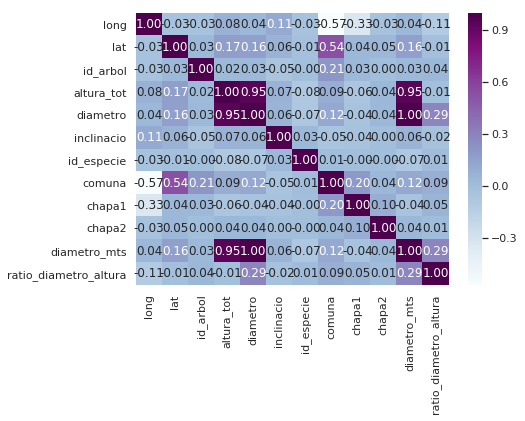

In [10]:
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (7, 5)
sns.set(font_scale=1)
sns.heatmap(df_arb.corr(), annot=True, fmt='.2f', cmap="BuPu");

Hacemos Dummies de los Barrios y creamos X e y

In [11]:
X = pd.get_dummies(df_arb[['diametro_mts', 'barrio']], drop_first=True)
y = df_arb[['altura_tot']]

Dividimos el dataset en Train y Test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Estandarizamos los datos

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Entrenamos Modelos Lineales

/home/gonzalo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


El 𝛼 estimado en Ridge: 3.3544 
El 𝛼 estimado en LASSO: 0.0100 

 Score Train Lineal: 0.8965
 Score Train Ridge : 0.8965
 Score Train Lasso : 0.8963

 Train RMSE lineal   : 1.48 
 Train RMSE Ridge    : 1.48 
 Train RMSE Lasso    : 1.48 

 Test R2 lineal= 0.8968
 Test R2 Ridge = 0.8968
 Test R2 Lasso = 0.8966

 Test RMSE lineal= 1.48
 Test RMSE Ridge = 1.48
 Test RMSE Lasso = 1.48


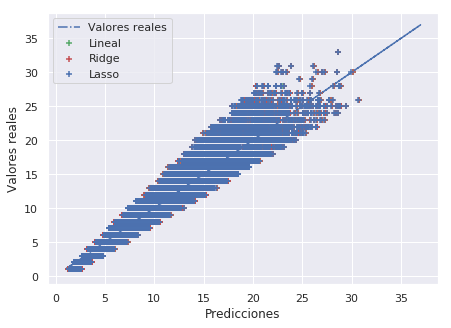

In [37]:
#Asignamos los alphas
alphas = np.linspace(0.01, 1000, 300)
# Definimos kf para utilizar kFold como estrategia de cross validation.
kf = KFold(n_splits=5, shuffle=True, random_state=68)

#Instanciamos los modelos 
lm = LinearRegression()
lm_ridge_cv= RidgeCV(alphas=alphas, cv=kf, normalize=False)
lm_lasso_cv = LassoCV(alphas=alphas, cv=kf, normalize=False)

# Entrenamos los modelos
modelo_lr = lm.fit(X_train, y_train)
modelo_ridge = lm_ridge_cv.fit(X_train, y_train)
modelo_lasso = lm_lasso_cv.fit(X_train, y_train)

#Imprimimos el alpha que eligio para cada modelo
print('El 𝛼 estimado en Ridge: %.4f'% lm_ridge_cv.alpha_,'\n'
      'El 𝛼 estimado en LASSO: %.4f'% lm_lasso_cv.alpha_,'\n')

print(" Score Train Lineal: %.4f\n" % lm.score(X_train, y_train),
      "Score Train Ridge : %.4f\n" % lm_ridge_cv.score(X_train, y_train),
      "Score Train Lasso : %.4f\n" %  lm_lasso_cv.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_lm = lm.predict(X_train)
y_pred_tr_ridge = lm_ridge_cv.predict(X_train)
y_pred_tr_lasso = lm_lasso_cv.predict(X_train)

print(" Train RMSE lineal   : %.2f \n" % rmse(y_train,y_pred_tr_lm),
      "Train RMSE Ridge    : %.2f \n" % rmse(y_train,y_pred_tr_ridge),
      "Train RMSE Lasso    : %.2f \n" % rmse(y_train,y_pred_tr_lasso))

# Hacemos las predicciones sobre la matriz de predictores del Test Set

y_pred_lm = lm.predict(X_test)
y_pred_ridge = lm_ridge_cv.predict(X_test)
y_pred_lasso = lm_lasso_cv.predict(X_test)

# Testeo final del modelo sobre Test Set

print(" Test R2 lineal= %.4f\n" % r2_score(y_test, y_pred_lm),
      "Test R2 Ridge = %.4f\n" %  r2_score(y_test, y_pred_ridge),
      "Test R2 Lasso = %.4f" %  r2_score(y_test, y_pred_lasso))
print()

print(" Test RMSE lineal= %.2f\n" % rmse(y_test, y_pred_lm),
      "Test RMSE Ridge = %.2f\n" %  rmse(y_test, y_pred_ridge),
      "Test RMSE Lasso = %.2f" %  rmse(y_test, y_pred_lasso))

plt.plot(y,y, '-.',c='b', label='Valores reales') 
plt.scatter(y_pred_lm, y_test, s=30, c='g', marker='+', zorder=10, label='Lineal')
plt.scatter(y_pred_ridge, y_test, s=30, c='r', marker='+', zorder=10, label='Ridge')
plt.scatter(y_pred_lasso, y_test, s=30, c='b', marker='+', zorder=10, label='Lasso')
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.legend()
plt.show()

### Decision Tree Regressor

In [15]:
dt = DecisionTreeRegressor( random_state=68, max_depth=10)

fitted_tree = dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

In [16]:
rmse( y_test, y_pred_dt )

1.4494640127307152

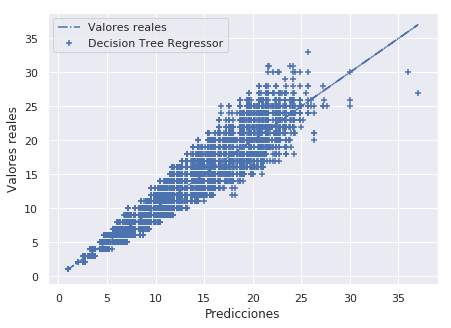

In [21]:
basic_plot(y, y_pred_dt, y_test, 'b', 'Decision Tree Regressor')

### Random Forest Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
y_pred_rf = RandomForestRegressor(n_estimators=300, n_jobs=-1).fit(X_train, y_train).predict(X_test)

/home/gonzalo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [24]:
rmse( y_test, y_pred_rf )

1.4497777311628348

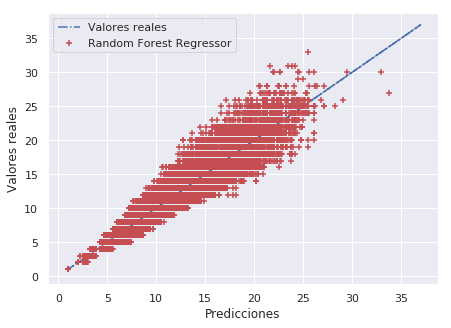

In [26]:
basic_plot(y, y_pred_rf, y_test, 'r', 'Random Forest Regressor')

### XGBoost Regressor

In [27]:
import xgboost as xgb
import scipy.stats as st

In [28]:
model_xgb = xgb.XGBRegressor(n_jobs=-1)

In [29]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

params = {  
    "n_estimators": st.randint(20,40), # Number of boosted trees to fit.
    "max_depth": st.randint(3, 12),     # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": one_to_left, #     Subsample ratio of columns when constructing each tree.
    "subsample": one_to_left,     # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
}

In [30]:
xgb_cv = RandomizedSearchCV(model_xgb, params, n_iter=25, verbose=True, n_jobs=-1)

In [31]:
xgb_cv.fit(X_train,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  5.2min finished


[18:10:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          ran...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fade8fd35f8>,
                                        'n_estimators': <

In [32]:
y_pred_xgb = xgb_cv.predict(X_test)

In [34]:
rmse( y_test, y_pred_xgb )

1.425508998365474

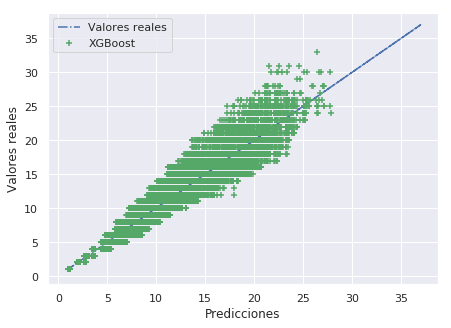

In [35]:
basic_plot(y, y_pred_xgb, y_test, 'g', 'XGBoost')